WeatherPy

In [1]:
# Dependencies and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
import json
from scipy import stats
from scipy.stats import linregress

# Import API key
from api_keys import weather_api

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90,90)
lng_range = (-180, 180)

Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat an lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats,lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name

    # If the city is unique, then add it to a cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

633

Perform API Calls

In [3]:
# Save url configuration
url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# See API layout
test_query = f"{url}q={city}&appid={weather_api}&units={units}"
test_response = requests.get(test_query)
test_json_response = test_response.json()
print(json.dumps(test_json_response, indent=4))

{
    "coord": {
        "lon": 27.2132,
        "lat": 35.507
    },
    "weather": [
        {
            "id": 800,
            "main": "Clear",
            "description": "clear sky",
            "icon": "01d"
        }
    ],
    "base": "stations",
    "main": {
        "temp": 82.36,
        "feels_like": 90.54,
        "temp_min": 82.36,
        "temp_max": 82.36,
        "pressure": 1009,
        "humidity": 83
    },
    "visibility": 10000,
    "wind": {
        "speed": 25.32,
        "deg": 310
    },
    "clouds": {
        "all": 0
    },
    "dt": 1624690999,
    "sys": {
        "type": 1,
        "id": 6620,
        "country": "GR",
        "sunrise": 1624676247,
        "sunset": 1624728622
    },
    "timezone": 10800,
    "id": 260895,
    "name": "Karpathos",
    "cod": 200
}


In [4]:
# Set empty lists to hold Temperature, Humidity, Cloudiness, Wind Speed, & Latitude
name = []
lat = []
lng = []
temp = []
humid = []
cloud = []
wind = []
country = []
date = []

# Create starting point for record count
record_count = 0

# Print beginning text
print(f"Beginning Data Retrieval")
print(f"-------------------------")


# Loop through each city
for city in cities:

    # Create search query, make reqeust and store in json
    query_url = f"{url}q={city}&appid={weather_api}&units={units}"
    response = requests.get(query_url)
    json_response = response.json()
    
    # Add to record count
    record_count = record_count + 1

    # Try to grab data if available in API
    try:
        name.append(json_response["name"])
        lat.append(json_response["coord"]["lat"])               
        lng.append(json_response["coord"]["lon"])               
        temp.append(json_response["main"]["temp_max"])
        humid.append(json_response["main"]["humidity"])
        cloud.append(json_response["clouds"]["all"])
        wind.append(json_response["wind"]["speed"])
        country.append(json_response["sys"]["country"])
        date.append(json_response["dt"])
        print(f"Processing Record {record_count}: {city}")
    
        

    # Handle exceptions for a city that is not available in SPI
    except:
        # Append null values
        print("City not found. Skipping...")
        pass

print(f"-------------------------")
print(f"Data Retrieval Complete")
print(f"-------------------------")

la
Processing Record 6: punta arenas
Processing Record 7: shingu
Processing Record 8: mahebourg
City not found. Skipping...
Processing Record 10: bintulu
Processing Record 11: nishihara
Processing Record 12: ribeira grande
Processing Record 13: teya
City not found. Skipping...
Processing Record 15: lebu
Processing Record 16: tura
Processing Record 17: zhangjiakou
City not found. Skipping...
Processing Record 19: jamestown
Processing Record 20: provideniya
Processing Record 21: terrace bay
Processing Record 22: dingle
Processing Record 23: severo-kurilsk
Processing Record 24: ulety
Processing Record 25: san fernando
Processing Record 26: rikitea
City not found. Skipping...
Processing Record 28: medeiros neto
Processing Record 29: reims
Processing Record 30: vila velha
Processing Record 31: roebourne
Processing Record 32: cape town
Processing Record 33: bredasdorp
Processing Record 34: vaini
Processing Record 35: port hedland
Processing Record 36: tuktoyaktuk
City not found. Skipping...


Convert Raw Data to DataFrame

In [5]:
# Create new dataframe 
cities_df = pd.DataFrame({"City": name, "Latitude": lat, "Longitude": lng, "Max Temperature": temp, "Humidity": humid, "Cloudiness": cloud, "Wind Speed": wind, "Country": country, "Date": date})
cities_df.to_csv("output_data/cities.csv")

# Convert date column from unix
cities_df["Date"] = pd.to_datetime(cities_df["Date"], unit="s", origin="unix")

# Prview new dataframe
cities_df.head()

,City,Latitude,Longitude,Max Temperature,Humidity,Cloudiness,Wind Speed,Country,Date
0,Cabo San Lucas,22.8909,-109.9124,82.81,76,2,8.01,MX,2021-06-26 07:02:14
1,Nikolskoye,59.7035,30.7861,73.29,92,99,4.70,RU,2021-06-26 07:03:23
2,Rawlins,41.7911,-107.2387,53.82,87,20,3.44,US,2021-06-26 07:03:24
3,Albany,42.6001,-73.9662,67.32,82,100,3.74,US,2021-06-26 07:00:03
4,Alyangula,-13.8483,136.4192,74.88,68,99,16.53,AU,2021-06-26 07:03:24


In [6]:
# Describe new dataframe to see if there are any cities with humidity greater than 100%
cities_df.describe()

,Latitude,Longitude,Max Temperature,Humidity,Cloudiness,Wind Speed
count,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000
mean,19.883070,19.591187,70.350744,67.352941,56.937716,7.779844
std,33.175419,89.171088,14.206176,21.582697,40.964197,5.475083
min,-54.800000,-175.200000,28.870000,5.000000,0.000000,0.000000
25%,-8.507700,-59.319000,61.517500,52.000000,9.250000,3.660000
50%,21.374550,24.196550,71.715000,72.000000,69.500000,6.630000
75%,48.303725,100.272375,80.912500,84.000000,100.000000,10.755000
max,78.218600,179.316700,106.140000,100.000000,100.000000,31.090000


In [7]:
# Confirm there are no rows with humdity greater than 100%
cities_df.loc[cities_df["Humidity"]>100]

,City,Latitude,Longitude,Max Temperature,Humidity,Cloudiness,Wind Speed,Country,Date


Plotting the Data

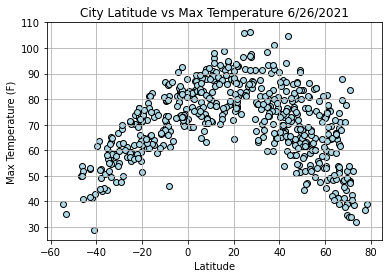

This plot shows the correlation between a cities latitide and its max temperature.
The closer you get to the equater (Latitude 0) the warmer the temperature is.


In [62]:
# Create plot for Latitude vs Temperature
plt.title("City Latitude vs Max Temperature 6/26/2021")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.scatter(cities_df["Latitude"], cities_df["Max Temperature"], marker="o", facecolors="lightblue", edgecolors="black")
plt.grid()
plt.show()
print("This plot shows the correlation between a cities latitide and its max temperature.")
print("The closer you get to the equater (Latitude 0) the warmer the temperature is.")

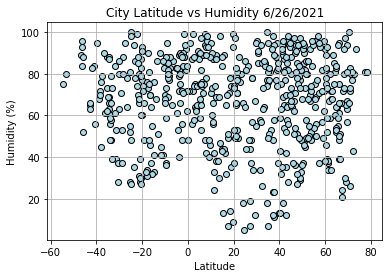

This plot shows the correlation between a cities latitide and its humidity.
Aside from the lowest humdity being around the 20-40 latitude area, there isn't much correlation.


In [63]:
# Create plot for Latitude vs Humidity
plt.title("City Latitude vs Humidity 6/26/2021")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.scatter(cities_df["Latitude"], cities_df["Humidity"], marker="o", facecolors="lightblue", edgecolors="black")
plt.grid()
plt.show()
print("This plot shows the correlation between a cities latitide and its humidity.")
print("Aside from the lowest humdity being around the 20-40 latitude area, there isn't much correlation.")

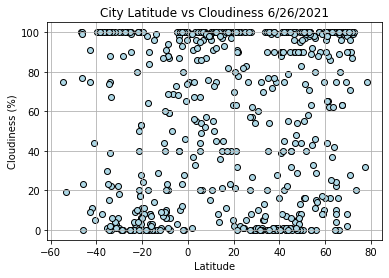

This plot shows the correlation between a cities latitide and its cloudiness.
There does not seem to be any correlation between latitutde and cloudiness.


In [64]:
# Create plot for Latitude vs Cloudiness
plt.title("City Latitude vs Cloudiness 6/26/2021")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.scatter(cities_df["Latitude"], cities_df["Cloudiness"], marker="o", facecolors="lightblue", edgecolors="black")
plt.grid()
plt.show()
print("This plot shows the correlation between a cities latitide and its cloudiness.")
print("There does not seem to be any correlation between latitutde and cloudiness.")

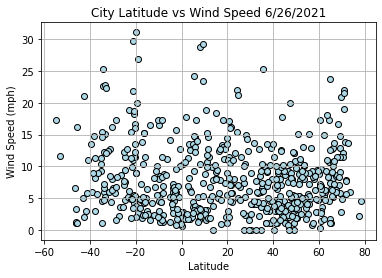

This plot shows the correlation between a cities latitide and its wind speed.
There are only a few instances where wind speeds are extremely high and there
doesn't seem to be a correlatin with latitude.


In [65]:
# Create plot for Latitude vs Wind Speed
plt.title("City Latitude vs Wind Speed 6/26/2021")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.scatter(cities_df["Latitude"], cities_df["Wind Speed"], marker="o", facecolors="lightblue", edgecolors="black")
plt.grid()
plt.show()
print("This plot shows the correlation between a cities latitide and its wind speed.")
print("There are only a few instances where wind speeds are extremely high and there")
print("doesn't seem to be a correlatin with latitude.")

Linear Regression by Hemisphere

In [66]:
# Create new dataframes for North and South hemispheres
north_df = cities_df[cities_df["Latitude"]>=0]
south_df = cities_df[cities_df["Latitude"]<0]

The r-value is: -0.640628358830827


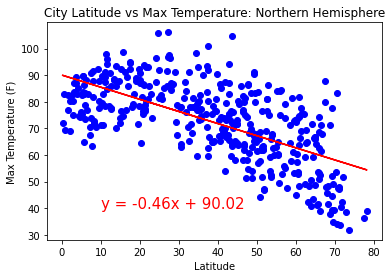

Similar to the first graph, this shows that the closer you get to the equator the warmer the temperature.
Although the highest temperatures beoong to those in the 25-40 latitude area.


In [78]:
# Create plot for Latitude vs Temperature for NORTHERN HEMISPHERE
x_values = north_df["Latitude"]
y_values = north_df["Max Temperature"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Max Temperature: Northern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.scatter(north_df["Latitude"], north_df["Max Temperature"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(10,40),fontsize=15,color="red")
print(f"The r-value is: {rvalue}")
plt.show()
print("Similar to the first graph, this shows that the closer you get to the equator the warmer the temperature.")
print("Although the highest temperatures beoong to those in the 25-40 latitude area.")

The r-value is: 0.7824625916943003


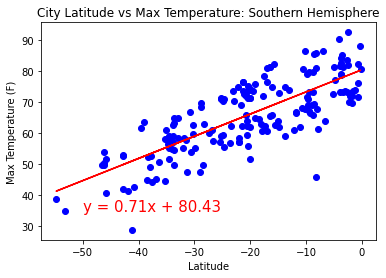

Again, the closer you get to the equator the warmer the temperature. Both hemispheres have strong correlations,
but the correlation in the southern hemisphere is greater as indicated by the greater r-value.


In [80]:
# Create plot for Latitude vs Temperature for SOUTHERN HEMISPHERE
x_values = south_df["Latitude"]
y_values = south_df["Max Temperature"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Max Temperature: Southern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Max Temperature (F)")
plt.scatter(south_df["Latitude"], south_df["Max Temperature"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,35),fontsize=15,color="red")
print(f"The r-value is: {rvalue}")
plt.show()
print("Again, the closer you get to the equator the warmer the temperature. Both hemispheres have strong correlations,")
print("but the correlation in the southern hemisphere is greater as indicated by the greater r-value.")

The r-value is: -0.004387712407270601


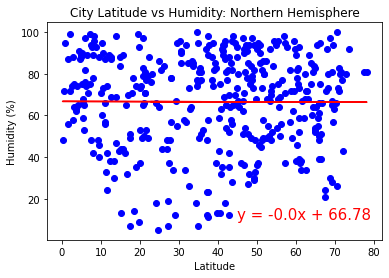

As shown by the r-value (close to 0) there is no correlation between the latitutde and humdiity for the Northern hemisphere.
There is a greater concentration of cities with humidity greater than 50%, but it is across all latitudes.


In [81]:
# Create plot for Latitude vs Humidity for NORTHERN HEMISPHERE
x_values = north_df["Latitude"]
y_values = north_df["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Humidity: Northern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.scatter(north_df["Latitude"], north_df["Humidity"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(45,10),fontsize=15,color="red")
print(f"The r-value is: {rvalue}")
plt.show()
print("As shown by the r-value (close to 0) there is no correlation between the latitutde and humdiity for the Northern hemisphere.")
print("There is a greater concentration of cities with humidity greater than 50%, but it is across all latitudes.")

The r-value is: 0.06805164306500545


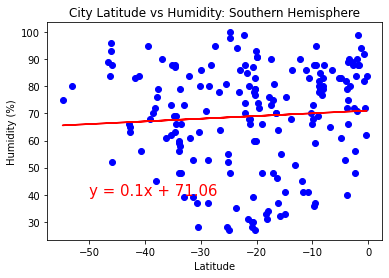

Though the r-value for the Southern hemisphere is greater than the Northern, 
there still is not a strong correlation between the latitude and humidity


In [83]:
# Create plot for Latitude vs Humidity for SOUTHERN HEMISPHERE
x_values = south_df["Latitude"]
y_values = south_df["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Humidity: Southern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.scatter(south_df["Latitude"], south_df["Humidity"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,40),fontsize=15,color="red")
print(f"The r-value is: {rvalue}")
plt.show()
print("Though the r-value for the Southern hemisphere is greater than the Northern, ")
print("there still is not a strong correlation between the latitude and humidity")

The r-value is: -0.03894212366173428


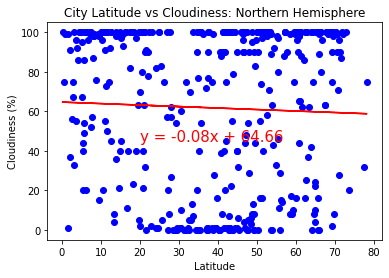

There seems to be a stronger concetration of cities in the extreme high and extreme low percentages.
of cloudiness, however no correlation to latitude.


In [85]:
# Create plot for Latitude vs Cloudiness for NORTHERN HEMISPHERE
x_values = north_df["Latitude"]
y_values = north_df["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Cloudiness: Northern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.scatter(north_df["Latitude"], north_df["Cloudiness"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(20,45),fontsize=15,color="red")
print(f"The r-value is: {rvalue}")
plt.show()
print("There seems to be a stronger concetration of cities in the extreme high and extreme low percentages.")
print("of cloudiness, however no correlation to latitude.")

The r-value is: -0.011046122598047405


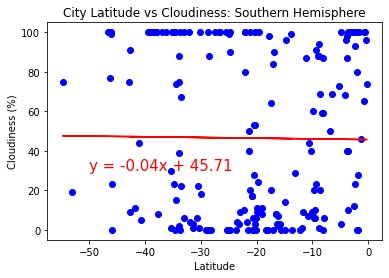

This plot shows the correlation between a cities latitide and its max temperature.


In [86]:
# Create plot for Latitude vs Cloudiness for SOUTHERN HEMISPHERE
x_values = south_df["Latitude"]
y_values = south_df["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Cloudiness: Southern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.scatter(south_df["Latitude"], south_df["Cloudiness"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,30),fontsize=15,color="red")
print(f"The r-value is: {rvalue}")
plt.show()
print("This plot shows the correlation between a cities latitide and its max temperature.")

The r-value is: -0.022870491144947342


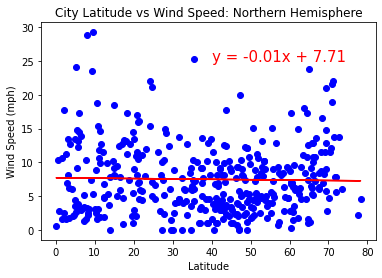

There are no very many places with high wind speed, however there is no
correlation between wind speed and latitutde.


In [87]:
# Create plot for Latitude vs Wind Speed for NORTHERN HEMISPHERE
x_values = north_df["Latitude"]
y_values = north_df["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Wind Speed: Northern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.scatter(north_df["Latitude"], north_df["Wind Speed"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(40,25),fontsize=15,color="red")
print(f"The r-value is: {rvalue}")
plt.show()
print("There are no very many places with high wind speed, however there is no")
print("correlation between wind speed and latitutde.")

The r-value is: -0.20717299166277206


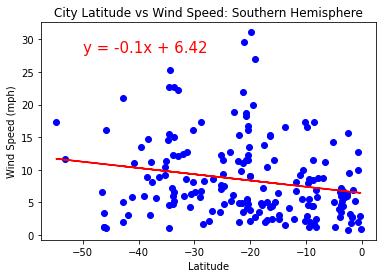

There is a greater correlation in the southern hemisphere between wind speed
and latitude, with the wind speeds picking up the further away you get from
the equator, but it's not a strong correlation.


In [90]:
# Create plot for Latitude vs Wind Speed for SOUTHERN HEMISPHERE
x_values = south_df["Latitude"]
y_values = south_df["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.title("City Latitude vs Wind Speed: Southern Hemisphere")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.scatter(south_df["Latitude"], south_df["Wind Speed"], marker="o", facecolors="blue", edgecolors="blue")
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(-50,28),fontsize=15,color="red")
print(f"The r-value is: {rvalue}")
plt.show()
print("There is a greater correlation in the southern hemisphere between wind speed")
print("and latitude, with the wind speeds picking up the further away you get from")
print("the equator, but it's a weak correlation.")